### Jax Intro

In [381]:
import jax
import numpy as np
import jax.numpy as jnp

import plotly as ply
import plotly.graph_objects as go

### Gradients, Jacobians, VMAP and JIT

In [382]:
# define a vector -> scalar function
def f(x: jnp.DeviceArray) -> jnp.DeviceArray:
    return (x ** 2).sum()

In [383]:
# define a point x0=(1, 2), and the two basis vectors
x0 = jnp.array([1.0, 2.0])
v1 = jnp.array([1.0, 0.0])
v2 = jnp.array([0.0, 1.0])

# The JVP takes:
#   - a point `x0` in the input space of the function
#   - a vector in the tangent space of `f(x0)`
# And returns:
#   - the value y = f(x)
#   - a vector in the codomain of f (the pushforward map of `v`)
# By evaluating each of the basis vectors in the tangent space, we can construct 
# the jacobian (i.e one column at a time).
y, u1 = jax.jvp(f, (x0,), (v1,))
_, u2 = jax.jvp(f, (x0,), (v2,))
jac = jnp.stack((u1, u2), axis=0)
jac

DeviceArray([2., 4.], dtype=float32)

In [384]:
# We can confirm this result with the inbuilt `jacfwd`
# Another way to think about this - we are taking the partial derivative of `f` with respect
# to each of its inputs. Can be done with forward or reverse mode.
jax.jacfwd(f)(x0)

DeviceArray([2., 4.], dtype=float32)

In [385]:
# OR, equivalently...
# However, note that `grad` only works for scalar output functions!
jax.grad(f, argnums=0)(x0)

DeviceArray([2., 4.], dtype=float32)

In [386]:
# The jacobian defines a tangent plane.
# e.g) for a 2-variable z = f(x,y):
# z = f(x0, y0) + f_x(x0)(x - x0) + f_y(x0)(y - y0)
def tangent(f, x0, jac):
    f0 = f(x0)
    return lambda x: f0 + (jac * (x - x0)).sum()

# get the function of the tangent plane at x0
T = tangent(f, x0, jac)

In [387]:
# create a set of linearly spaced x, y co-ordinates to evaluate the
# function and its tangent at x0
points = jnp.linspace(-7, 7, 100)
x_grid, y_grid = jnp.meshgrid(points, points)
grid_stack = jnp.stack((x_grid, y_grid), axis=2) # (100, 100, 2)
grid_flat = grid_stack.reshape([-1, 2])

In [388]:
# vectorise on batch dimension, and compile with jit
T_batch = jax.jit(vmap(T, in_axes=0, out_axes=0))
f_batch = jax.jit(vmap(f, in_axes=0, out_axes=0))

In [389]:
# evaluate the function at tangent function at each grid location
z = np.array(f_batch(grid_flat))
z_tangent = np.array(T_batch(grid_flat))

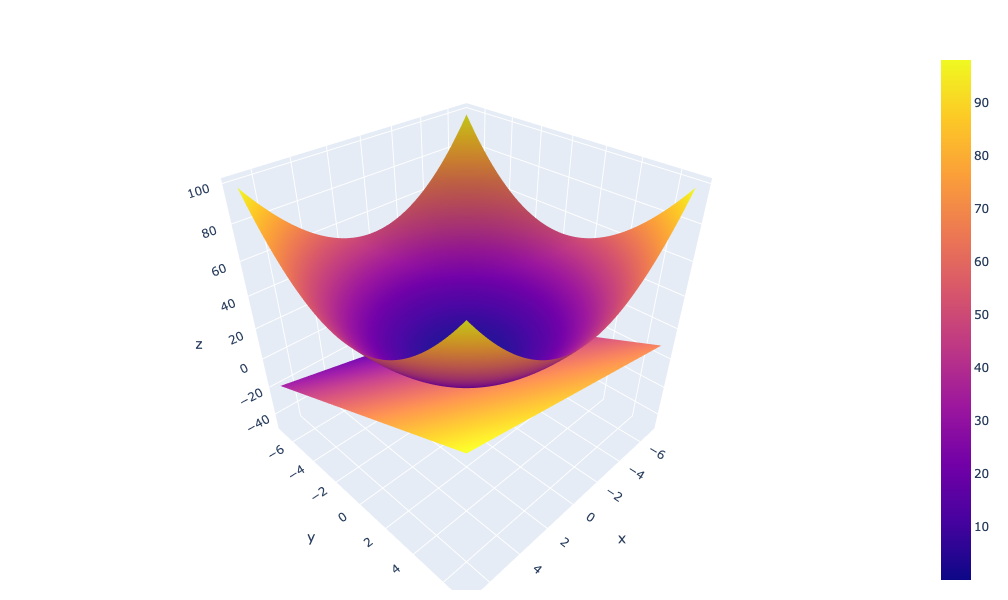

In [390]:
# visualize
x = grid_flat[:, 0].reshape([100, 100])
y = grid_flat[:, 1].reshape([100, 100])
z = z.reshape([100, 100])
z_tangent = z_tangent.reshape([100, 100])

fig = go.Figure(data = [
    go.Surface(x=x_grid, y=y_grid, z=z),
    go.Surface(x=x, y=y, z=z_tangent, showscale=False)
])
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=20, r=20, b=10, t=50, pad=4),
)

fig.show()

### A Toy Problem - Iris Classification

In [394]:
import plotly.express as px

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

In [395]:
df = px.data.iris()

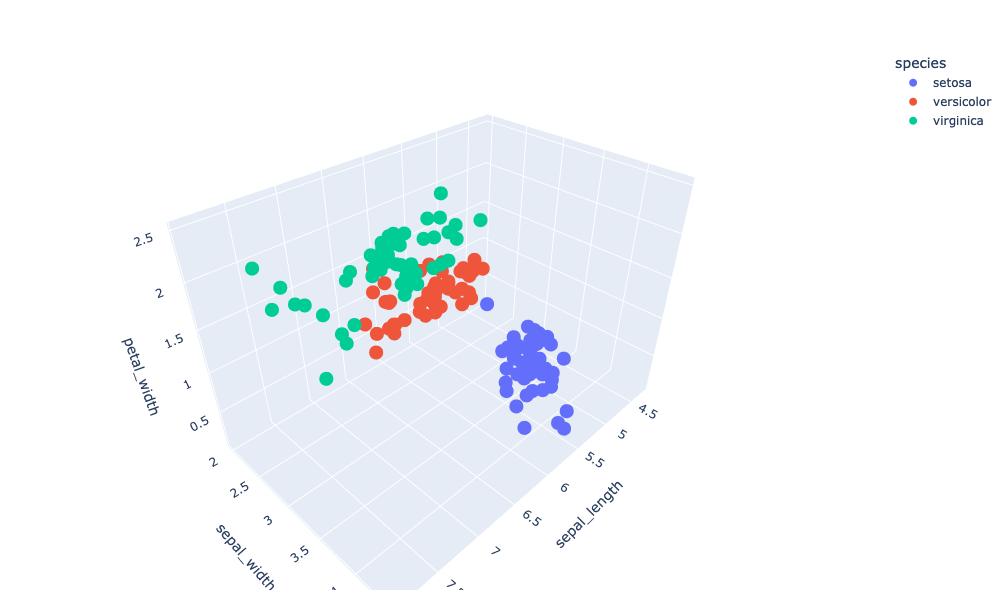

In [396]:
fig = px.scatter_3d(df, x='sepal_length', y='sepal_width', z='petal_width',
              color='species')
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=20, r=20, b=10, t=50, pad=4),
)
fig.show()

In [397]:
# create design matrix, and get labels
X = np.stack([df[feature] for feature in ('sepal_length', 'sepal_width', 'petal_width')], axis=1)
label_map = {
    'setosa': 0,
    'versicolor': 1,
    'virginica': 2
}
y = np.array([label_map[x] for x in df['species']])

### MLP Classifier - Vanilla JAX

In [398]:
def init_mlp_params(layer_widths):
    params = []
    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        layer = {
            'weights': np.random.normal(size=(n_in, n_out)) * np.sqrt(2 / n_in),
            'biases': np.ones(shape=(n_out,))
        }
        params.append(layer)
    return params

In [399]:
# define the mlp for a single item
def mlp(params, x):
    *hidden, last = params
    for layer in hidden:
        x = jax.nn.tanh(x @ layer['weights'] + layer['biases'])
    logits = x @ last['weights'] + last['biases']
    return jax.nn.softmax(logits)

In [400]:
# define the cross-entropy for a single item
def ce_loss(preds, target, nb_classes=3):
    one_hot = jax.nn.one_hot(target, nb_classes)
    return -jnp.sum(one_hot * jnp.log(preds))

In [401]:
# define the loss wrt to the parameters and a batch of inputs
def loss_fn(params, x, y):
    preds = jax.vmap(mlp, in_axes=(None, 0), out_axes=0)(params, x)
    loss = jax.vmap(ce_loss, in_axes=(0, 0), out_axes=0)(preds, y)
    return np.mean(loss)

In [412]:
# define the optimizer - i.e) vanilla grad-descent
def optim_step(param, grad, lr=3e-3, weight_decay=1e-5):
    return (1. - lr * weight_decay) * param - lr * grad

@jit
def update(params, x, y):
    loss, grads = jax.value_and_grad(loss_fn, argnums=0)(params, x, y)
    new_params = jax.tree_multimap(optim_step, params, grads)
    return loss, new_params

@jit
def evaluate(params, x, y):
    preds = jax.vmap(mlp, in_axes=(None, 0), out_axes=0)(params, x)
    loss = jax.vmap(ce_loss, in_axes=(0, 0), out_axes=0)(preds, y)
    acc = (jnp.argmax(preds, axis=1) == y).mean()
    return np.mean(loss), acc

In [413]:
# train/test split
np.random.seed(0)
mask = np.random.rand(X.shape[0]) < 0.7
X_train, X_test = X[mask], X[~mask]
y_train, y_test = y[mask], y[~mask]

In [414]:
layer_sizes = [3, 8, 3]
params = init_mlp_params(layer_sizes)
train_losses, test_losses, accs = [], [], []
prev_loss = None
for i in tqdm(range(100000)):
    # optimize
    train_loss, params = update(params, X_train, y_train)
    test_loss, acc = evaluate(params, X_test, y_test)
    
    # early stopping
    if prev_loss is not None:
        diff = prev_loss - test_loss
        if diff < 1e-4:
            print(f"Stopping at iteration: {i}")
            break
    prev_loss = test_loss
    
    # accumulate metrics
    accs.append(acc.item())
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

  2%|▏         | 2227/100000 [00:01<01:17, 1266.06it/s]

Stopping at iteration: 2227


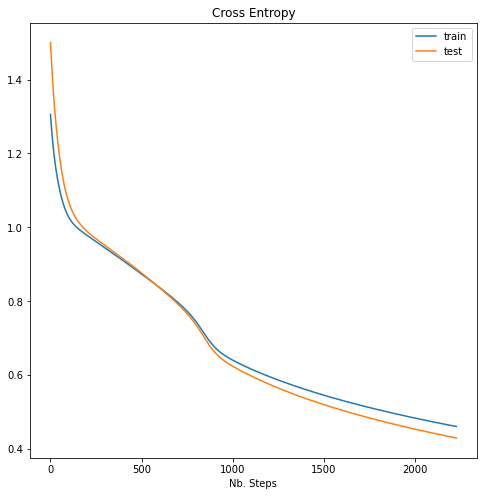

In [415]:
plt.figure(figsize=(8, 8))
plt.title("Cross Entropy")
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("Nb. Steps")
plt.legend()
plt.show()

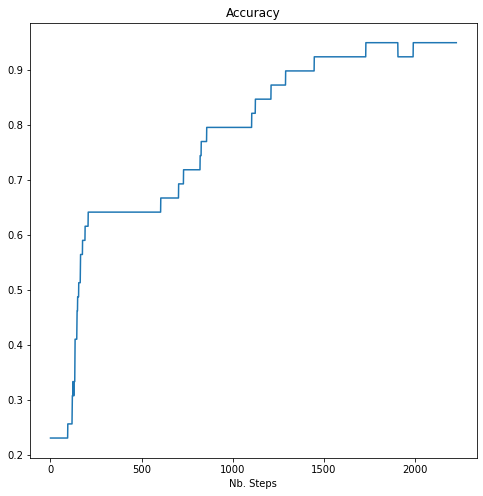

In [416]:
plt.figure(figsize=(8, 8))
plt.title("Accuracy")
plt.xlabel("Nb. Steps")
plt.plot(accs)
plt.show()

### MLP Classifier - Flax Linen